In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile


zip_path = "/content/animal_dataset.zip"
extract_path = "/content/animal_dataset"

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

extracted_contents = os.listdir(extract_path)
if len(extracted_contents) == 1 and os.path.isdir(os.path.join(extract_path, extracted_contents[0])):

    extract_path = os.path.join(extract_path, extracted_contents[0])

classes = ['cat', 'dog', 'panda']
img_size = 32


X = []
Y = []

for label, cls in enumerate(classes):
    folder_path = os.path.join(extract_path, cls)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        X.append(img.flatten())
        Y.append(label)

X = np.array(X)
Y = np.array(Y)

print("Dataset Loaded:")
print("X shape:", X.shape)
print("Y shape:", Y.shape)


Dataset Loaded:
X shape: (300, 1024)
Y shape: (300,)


In [3]:
def L1_distance(a, b):
    return np.sum(np.abs(a - b))

def L2_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))


In [4]:
def knn_predict(x, X_train, Y_train, k, dist_type="L2"):
    distances = []

    for i in range(len(X_train)):
        if dist_type == "L1":
            d = L1_distance(x, X_train[i])
        else:
            d = L2_distance(x, X_train[i])
        distances.append((d, Y_train[i]))

    distances.sort(key=lambda z: z[0])
    k_labels = [label for _, label in distances[:k]]


    values, counts = np.unique(k_labels, return_counts=True)
    return values[np.argmax(counts)]


In [5]:
def five_fold_split(X, Y):
    idx = np.arange(len(X))
    np.random.shuffle(idx)

    fold_size = len(X) // 5
    folds = []

    for i in range(5):
        valid_idx = idx[i * fold_size:(i + 1) * fold_size]
        train_idx = np.setdiff1d(idx, valid_idx)

        folds.append((train_idx, valid_idx))
    return folds

folds = five_fold_split(X, Y)


In [6]:
K_values = [1, 3, 5, 7, 9]
acc_L1 = []
acc_L2 = []

for k in K_values:
    fold_acc_L1 = []
    fold_acc_L2 = []

    for train_idx, val_idx in folds:
        X_train, Y_train = X[train_idx], Y[train_idx]
        X_val, Y_val = X[val_idx], Y[val_idx]

        preds_L1 = []
        preds_L2 = []

        for x in X_val:
            preds_L1.append(knn_predict(x, X_train, Y_train, k, dist_type="L1"))
            preds_L2.append(knn_predict(x, X_train, Y_train, k, dist_type="L2"))

        fold_acc_L1.append(np.mean(np.array(preds_L1) == Y_val))
        fold_acc_L2.append(np.mean(np.array(preds_L2) == Y_val))

    acc_L1.append(np.mean(fold_acc_L1))
    acc_L2.append(np.mean(fold_acc_L2))

print("Accuracy L1:", acc_L1)
print("Accuracy L2:", acc_L2)


Accuracy L1: [np.float64(0.4033333333333333), np.float64(0.4033333333333333), np.float64(0.42666666666666664), np.float64(0.4633333333333334), np.float64(0.44000000000000006)]
Accuracy L2: [np.float64(0.37666666666666665), np.float64(0.4), np.float64(0.4133333333333334), np.float64(0.42666666666666664), np.float64(0.4333333333333333)]


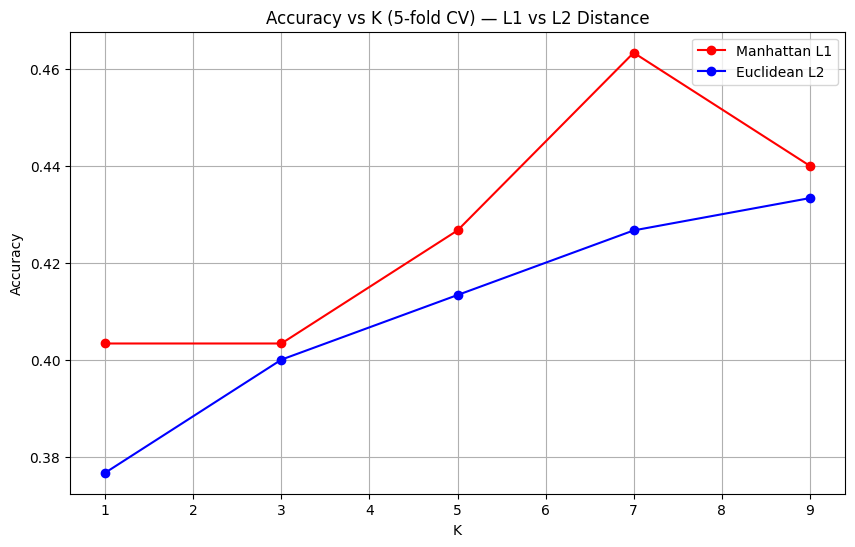

In [7]:
plt.figure(figsize=(10,6))
plt.plot(K_values, acc_L1, marker='o', color='red', label='Manhattan L1')
plt.plot(K_values, acc_L2, marker='o', color='blue', label='Euclidean L2')

plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Accuracy vs K (5-fold CV) — L1 vs L2 Distance")
plt.legend()
plt.grid(True)
plt.show()


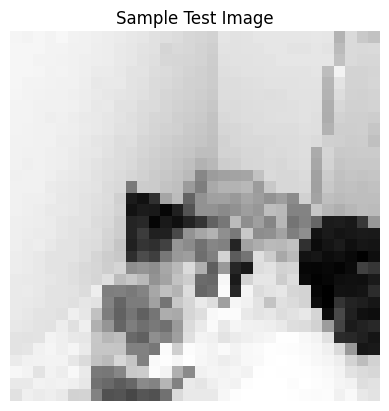

Top-5 Predictions (Euclidean L2):
[('cat', np.float64(0.0)), ('dog', np.float64(308.2644968205064)), ('cat', np.float64(308.90775322092514)), ('cat', np.float64(311.6953640977036)), ('cat', np.float64(312.79546032511405))]


In [8]:
def top5_predictions(x, X_train, Y_train, dist_type="L2"):
    dist_list = []

    for i in range(len(X_train)):
        if dist_type == "L1":
            d = L1_distance(x, X_train[i])
        else:
            d = L2_distance(x, X_train[i])
        dist_list.append((d, Y_train[i]))

    dist_list.sort(key=lambda z: z[0])
    top5 = dist_list[:5]

    return [(classes[label], d) for d, label in top5]

# pick 1 test image
test_img = X[10].reshape(32,32)

plt.imshow(test_img, cmap='gray')
plt.title("Sample Test Image")
plt.axis('off')
plt.show()

print("Top-5 Predictions (Euclidean L2):")
print(top5_predictions(X[10], X, Y, dist_type="L2"))
